In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn

# import pytorch_lightning as pl
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchmetrics as TM
# pl.utilities.seed.seed_everything(seed=42)
import numpy as np
import pandas as pd

import sys, os
source_path = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(source_path)
source_path = os.path.join(os.getcwd(), os.pardir, 'preprocessing')
sys.path.append(source_path)
source_path = os.path.join(os.getcwd(), os.pardir, 'metrics')
sys.path.append(source_path)
import matplotlib.pyplot as plt

from dl import NeuralNetwork, Trainer
from preprocess import (
    show_df, 
    date_features, 
    preprocess, 
    ToTorch, 
    get_loader, 
    ts_split,
    cont_cat_split,
    dataloader_by_stock,
    get_data
)
from metrics import calc_spread_return_sharpe
print(torch.__version__)
import pickle

import warnings
warnings.filterwarnings("ignore")

C:\Users\gilbe\anaconda3\envs\tokyo\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.11.0


In [2]:
print(torch.version.cuda), torch.cuda.is_available(), torch.cuda.device_count()

11.3


(None, True, 1)

##  Get Data and train a Neural Network

# Get the unique security codes

In [3]:
train_df = get_data()
print('Unique adjustment factor:', train_df['AdjustmentFactor'].unique())
print(train_df['AdjustmentFactor'])
train_df.head()

Unique adjustment factor: [ 1.          0.5         5.          0.33333333  0.83333333  0.25
  0.90909091  0.1        10.          0.2         0.95238095  2.
  0.14285714  0.66666667  0.86956522  0.76923077  0.8         4.
 20.        ]
Date
2017-01-04    1.0
2017-01-04    1.0
2017-01-04    1.0
2017-01-04    1.0
2017-01-04    1.0
             ... 
2021-12-03    1.0
2021-12-03    1.0
2021-12-03    1.0
2021-12-03    1.0
2021-12-03    1.0
Name: AdjustmentFactor, Length: 2332531, dtype: float64


,RowId,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
Date,,,,,,,,,,,
2017-01-04,20170104_1301,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
2017-01-04,20170104_1332,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2017-01-04,20170104_1333,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
2017-01-04,20170104_1376,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
2017-01-04,20170104_1377,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026


# Create model

### Args and constants

In [4]:
CONT_COLS=['Close', 'Open', 'High', 'Low']
TS_IN_FEATURES = len(CONT_COLS)
CAT_FEATURES = 4 #cat.shape[1]
print('CAT_FEATURES:', CAT_FEATURES)
EMBEDDING_DIM = 300
NO_EMBEDDING = 2000 #2 * len(df_train_cat)

CAT_FEATURES: 4


In [5]:

def create_model():
    model = None
    model = NeuralNetwork(
        in_features=TS_IN_FEATURES, 
        units=128,
        out_features=1, 
        categorical_dim=CAT_FEATURES,
        no_embedding=NO_EMBEDDING, 
        emb_dim=EMBEDDING_DIM,
        n_blocks=4,
        n_stacks=2,
        dropout=0.3,
        pooling_sizes=3
    )

    print(model)
    return model

# Loop throug each stock
Create Trainer only once

NeuralNetwork(
  (embedding_layer): Embedding(2000, 300)
  (embedding_to_hidden): Linear(in_features=300, out_features=128, bias=True)
  (embedding_output): Linear(in_features=128, out_features=1, bias=True)
  (cont_input): Linear(in_features=2, out_features=128, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (pooling_layer): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=True)
  (stacks): ModuleList(
    (0): NeuralStack(
      (blocks): ModuleList(
        (0): NeuralBlock(
          (dropout): Dropout(p=0.1, inplace=False)
          (layer1): Linear(in_features=132, out_features=132, bias=True)
          (layer2): Linear(in_features=132, out_features=132, bias=True)
          (layer3): Linear(in_features=132, out_features=132, bias=True)
          (layer4): Linear(in_features=132, out_features=132, bias=True)
          (fwr_layer): Linear(in_features=132, out_features=132, bias=True)
          (output): Linear(in_features=132, out_features=132, bias=Tru

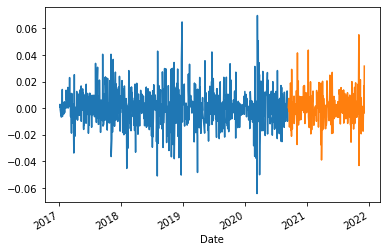

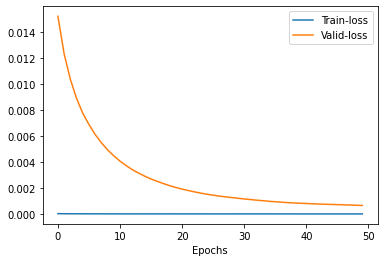

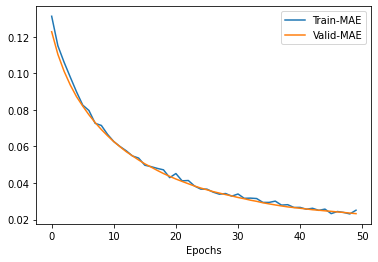

####################

Start training for stock: 1332
continuos shape: (1202, 9)  categorical shape: (1202, 4)
Epoch: <<< 0 >>>

                    Average train loss: 7.75856024120003e-07 | 
                    Train-Mae: 0.026239704340696335 |

                    Average val loss: 0.0008383166859857738|
                    Val-Mae: 0.024124586954712868
                    
.................... End of epoch 0 ....................
Epoch: <<< 10 >>>

                    Average train loss: 7.715563988313079e-07 | 
                    Train-Mae: 0.022935541346669197 |

                    Average val loss: 0.000724469602573663|
                    Val-Mae: 0.0220005102455616
                    
.................... End of epoch 10 ....................
Epoch: <<< 20 >>>

                    Average train loss: 7.588674779981375e-07 | 
                    Train-Mae: 0.022435205057263374 |

                    Average val loss: 0.0006535672582685947|
                    Val-Mae: 0.0205719

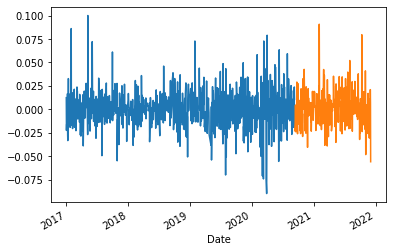

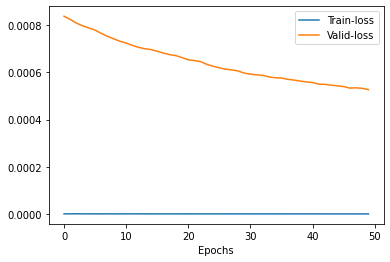

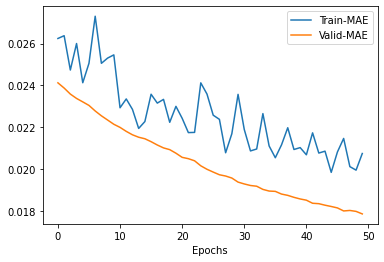

####################

Start training for stock: 1333
continuos shape: (1202, 9)  categorical shape: (1202, 4)
Epoch: <<< 0 >>>

                    Average train loss: 6.169450934976339e-07 | 
                    Train-Mae: 0.01797177828848362 |

                    Average val loss: 0.00040003887261264026|
                    Val-Mae: 0.01609627716243267
                    
.................... End of epoch 0 ....................
Epoch: <<< 10 >>>

                    Average train loss: 5.363287637010217e-07 | 
                    Train-Mae: 0.018225645646452904 |

                    Average val loss: 0.00037464615888893604|
                    Val-Mae: 0.015446716919541359
                    
.................... End of epoch 10 ....................


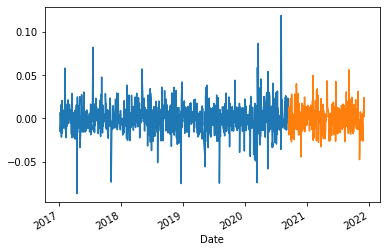

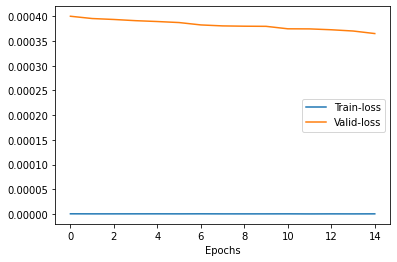

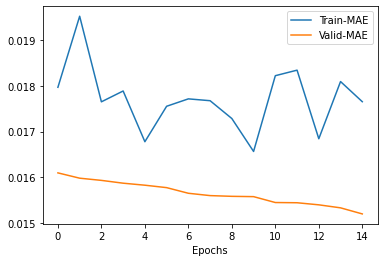

####################

Start training for stock: 1376
continuos shape: (1202, 9)  categorical shape: (1202, 4)
Epoch: <<< 0 >>>

                    Average train loss: 4.0209334110841155e-07 | 
                    Train-Mae: 0.02100796438753605 |

                    Average val loss: 0.0003310305764898658|
                    Val-Mae: 0.014477543532848358
                    
.................... End of epoch 0 ....................
Epoch: <<< 10 >>>

                    Average train loss: 3.740299725905061e-07 | 
                    Train-Mae: 0.020782988518476486 |

                    Average val loss: 0.0003067905781790614|
                    Val-Mae: 0.013778646476566792
                    
.................... End of epoch 10 ....................


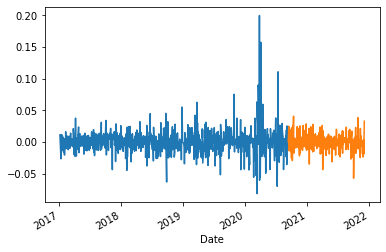

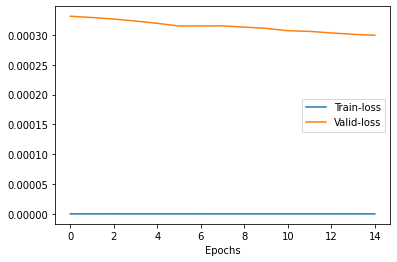

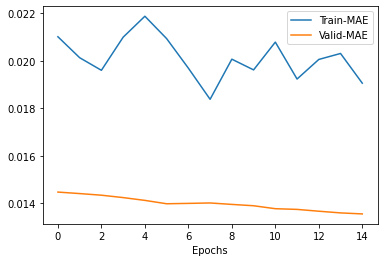

####################

Start training for stock: 1377
continuos shape: (1202, 9)  categorical shape: (1202, 4)
Epoch: <<< 0 >>>

                    Average train loss: 4.478972405195236e-07 | 
                    Train-Mae: 0.01771964691579342 |

                    Average val loss: 0.00030485671595670283|
                    Val-Mae: 0.01319090835750103
                    
.................... End of epoch 0 ....................
Epoch: <<< 10 >>>

                    Average train loss: 4.2247993405908344e-07 | 
                    Train-Mae: 0.01659323275089264 |

                    Average val loss: 0.00028821817249991|
                    Val-Mae: 0.0127149298787117
                    
.................... End of epoch 10 ....................


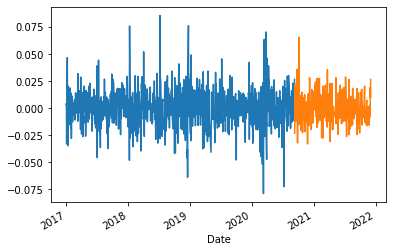

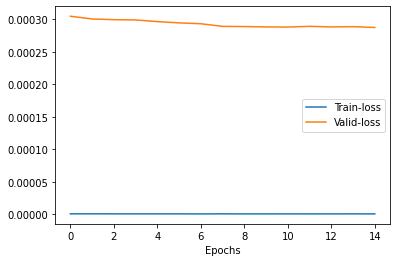

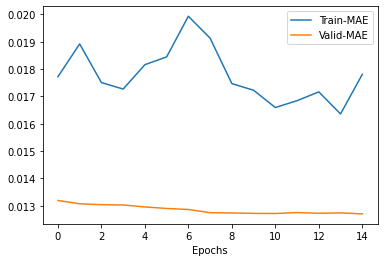

####################

Start training for stock: 1379
continuos shape: (1202, 9)  categorical shape: (1202, 4)
Epoch: <<< 0 >>>

                    Average train loss: 2.6085157878696917e-07 | 
                    Train-Mae: 0.01656372658908367 |

                    Average val loss: 0.00023823828087188303|
                    Val-Mae: 0.010809438303112984
                    
.................... End of epoch 0 ....................
Epoch: <<< 10 >>>

                    Average train loss: 2.490180486347526e-07 | 
                    Train-Mae: 0.015593351796269417 |

                    Average val loss: 0.0002240691101178527|
                    Val-Mae: 0.010375871323049068
                    
.................... End of epoch 10 ....................


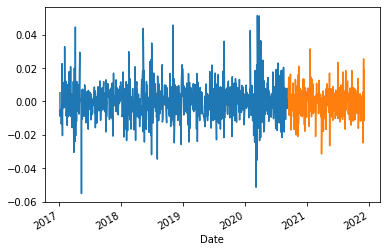

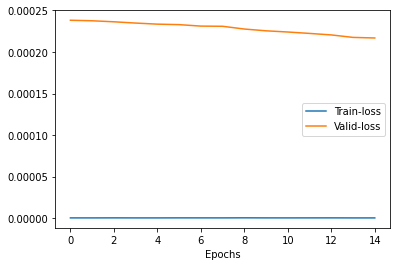

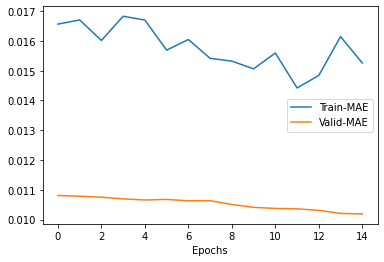

####################

Start training for stock: 1381
continuos shape: (1202, 9)  categorical shape: (1202, 4)
Epoch: <<< 0 >>>

                    Average train loss: 7.841042242944241e-07 | 
                    Train-Mae: 0.015805184841156006 |

                    Average val loss: 0.0002704888174775988|
                    Val-Mae: 0.01290552131831646
                    
.................... End of epoch 0 ....................
Epoch: <<< 10 >>>

                    Average train loss: 8.028355659916997e-07 | 
                    Train-Mae: 0.014734226278960705 |

                    Average val loss: 0.00024700010544620454|
                    Val-Mae: 0.01215954590588808
                    
.................... End of epoch 10 ....................


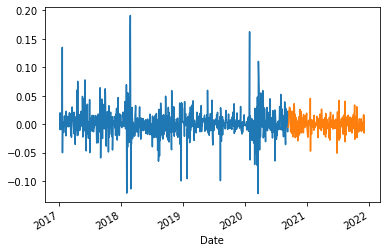

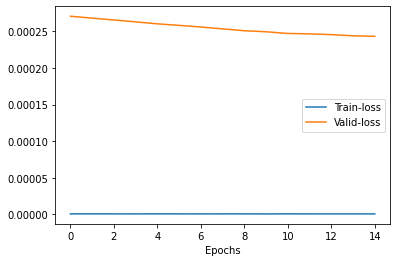

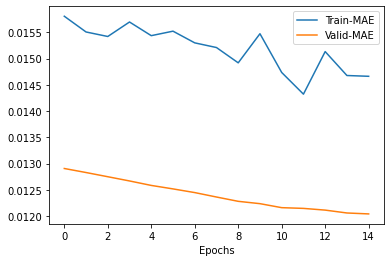

####################

Start training for stock: 1407
continuos shape: (1202, 9)  categorical shape: (1202, 4)
Epoch: <<< 0 >>>

                    Average train loss: 6.810657796449959e-07 | 
                    Train-Mae: 0.026577508077025414 |

                    Average val loss: 0.00595561508089304|
                    Val-Mae: 0.033986154943704605
                    
.................... End of epoch 0 ....................
Epoch: <<< 10 >>>

                    Average train loss: 6.903506582602859e-07 | 
                    Train-Mae: 0.02462759241461754 |

                    Average val loss: 0.0050804163329303265|
                    Val-Mae: 0.03315846621990204
                    
.................... End of epoch 10 ....................


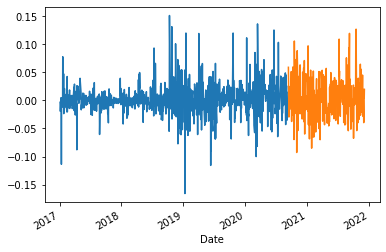

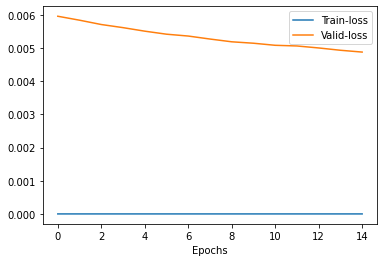

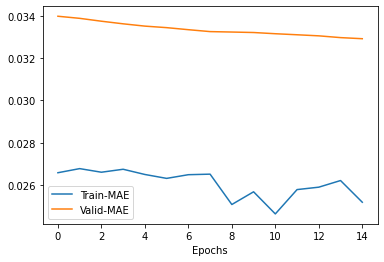

####################

Start training for stock: 1414
continuos shape: (1202, 9)  categorical shape: (1202, 4)
Epoch: <<< 0 >>>

                    Average train loss: 3.099633613601327e-07 | 
                    Train-Mae: 0.01616021804511547 |

                    Average val loss: 0.00019094890740234405|
                    Val-Mae: 0.010809903964400291
                    
.................... End of epoch 0 ....................
Epoch 00011: reducing learning rate of group 0 to 6.6665e-06.
Epoch: <<< 10 >>>

                    Average train loss: 3.051104431506246e-07 | 
                    Train-Mae: 0.015459091402590275 |

                    Average val loss: 0.00019174563931301236|
                    Val-Mae: 0.010842422023415565
                    
.................... End of epoch 10 ....................


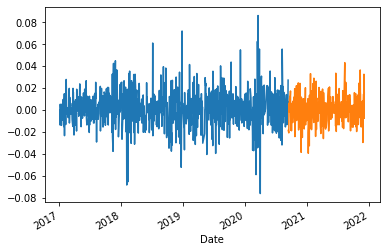

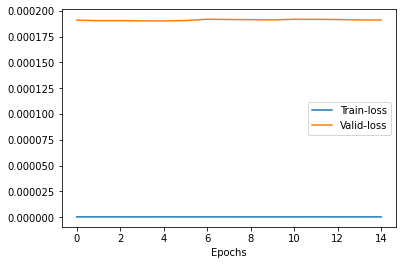

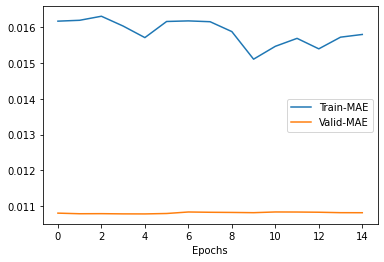

####################

Start training for stock: 1417
continuos shape: (1202, 9)  categorical shape: (1202, 4)
Epoch: <<< 0 >>>

                    Average train loss: 2.9430503491312267e-07 | 
                    Train-Mae: 0.013410956598818302 |

                    Average val loss: 0.00051543751033023|
                    Val-Mae: 0.013359746895730495
                    
.................... End of epoch 0 ....................
Epoch: <<< 10 >>>

                    Average train loss: 2.8388836653903127e-07 | 
                    Train-Mae: 0.013660551980137825 |

                    Average val loss: 0.000508859462570399|
                    Val-Mae: 0.013303793966770172
                    
.................... End of epoch 10 ....................


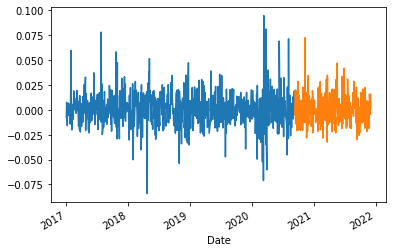

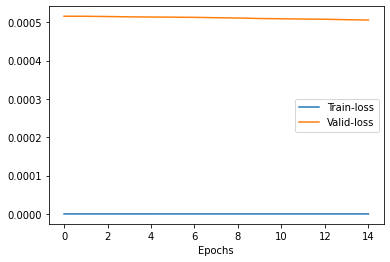

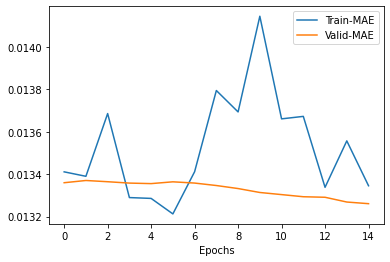

####################

Start training for stock: 1419
continuos shape: (1202, 9)  categorical shape: (1202, 4)
Epoch: <<< 0 >>>

                    Average train loss: 6.53695606160909e-07 | 
                    Train-Mae: 0.020528927445411682 |

                    Average val loss: 0.0015431017382070422|
                    Val-Mae: 0.019669879227876663
                    
.................... End of epoch 0 ....................
Epoch: <<< 10 >>>

                    Average train loss: 6.462937453761697e-07 | 
                    Train-Mae: 0.020277729257941246 |

                    Average val loss: 0.0014733225107192993|
                    Val-Mae: 0.019430089741945267
                    
.................... End of epoch 10 ....................


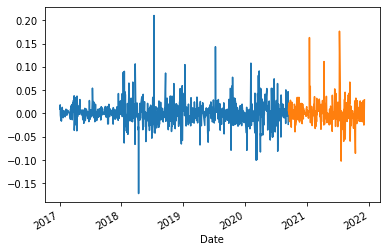

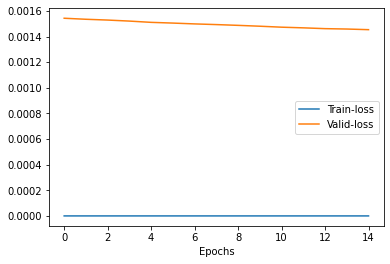

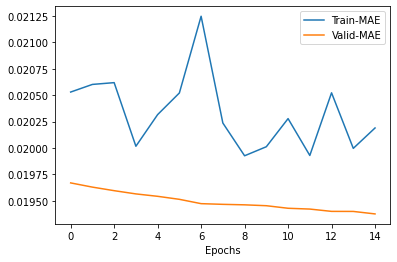

####################

Start training for stock: 1429
continuos shape: (1202, 9)  categorical shape: (1202, 4)
Epoch: <<< 0 >>>

                    Average train loss: 6.120717152953148e-07 | 
                    Train-Mae: 0.0226515494287014 |

                    Average val loss: 0.0004896463360637426|
                    Val-Mae: 0.014981911517679691
                    
.................... End of epoch 0 ....................
Epoch: <<< 10 >>>

                    Average train loss: 6.16866978816688e-07 | 
                    Train-Mae: 0.022372782230377197 |

                    Average val loss: 0.00048216822324320674|
                    Val-Mae: 0.014888281933963299
                    
.................... End of epoch 10 ....................


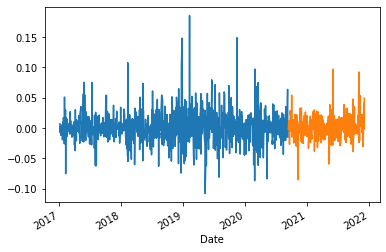

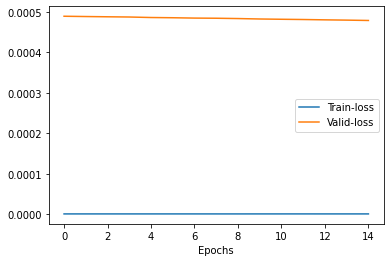

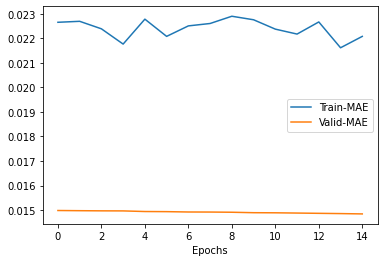

####################

Start training for stock: 1435
continuos shape: (1202, 9)  categorical shape: (1202, 4)
Epoch: <<< 0 >>>

                    Average train loss: 2.2961352951824663e-06 | 
                    Train-Mae: 0.027094362303614616 |

                    Average val loss: 0.001198147307150066|
                    Val-Mae: 0.022477205842733383
                    
.................... End of epoch 0 ....................
Epoch 00007: reducing learning rate of group 0 to 3.3332e-06.
Epoch: <<< 10 >>>

                    Average train loss: 2.3341625928878784e-06 | 
                    Train-Mae: 0.027056848630309105 |

                    Average val loss: 0.0012009799247607589|
                    Val-Mae: 0.02250410057604313
                    
.................... End of epoch 10 ....................
Epoch 00013: reducing learning rate of group 0 to 1.6666e-06.


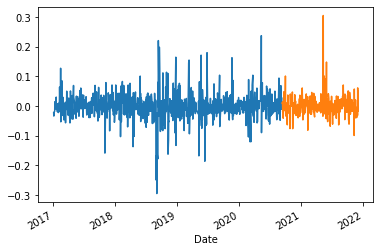

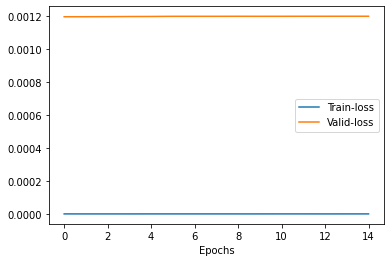

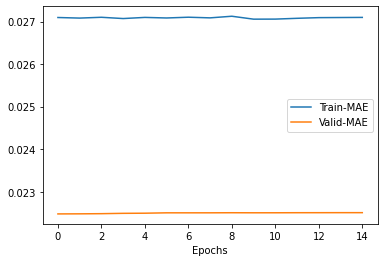

####################

Start training for stock: 1515
continuos shape: (1202, 9)  categorical shape: (1202, 4)
Epoch: <<< 0 >>>

                    Average train loss: 5.202353931963443e-07 | 
                    Train-Mae: 0.01689928211271763 |

                    Average val loss: 0.0006385104497894645|
                    Val-Mae: 0.0189433041960001
                    
.................... End of epoch 0 ....................
Epoch: <<< 10 >>>

                    Average train loss: 5.2824174053967e-07 | 
                    Train-Mae: 0.016912203282117844 |

                    Average val loss: 0.0006371793569996953|
                    Val-Mae: 0.018931837752461433
                    
.................... End of epoch 10 ....................


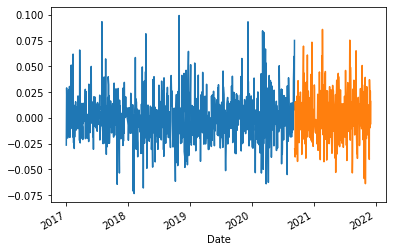

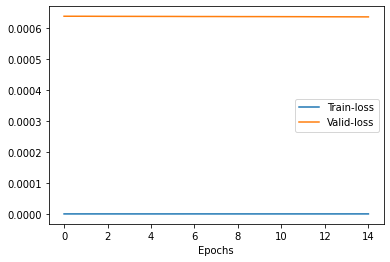

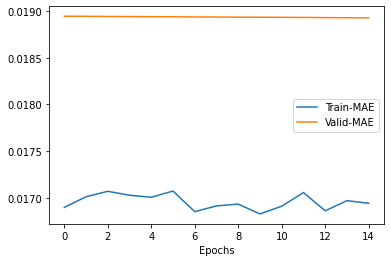

####################

Start training for stock: 1518
continuos shape: (1202, 9)  categorical shape: (1202, 4)
Epoch: <<< 0 >>>

                    Average train loss: 4.5738002518191935e-07 | 
                    Train-Mae: 0.01492081955075264 |

                    Average val loss: 0.0009558824822306633|
                    Val-Mae: 0.019850686192512512
                    
.................... End of epoch 0 ....................
Epoch 00007: reducing learning rate of group 0 to 8.3331e-07.
Epoch: <<< 10 >>>

                    Average train loss: 4.7150219324976203e-07 | 
                    Train-Mae: 0.015139782801270485 |

                    Average val loss: 0.0009559758473187685|
                    Val-Mae: 0.019852710887789726
                    
.................... End of epoch 10 ....................
Epoch 00013: reducing learning rate of group 0 to 4.1666e-07.


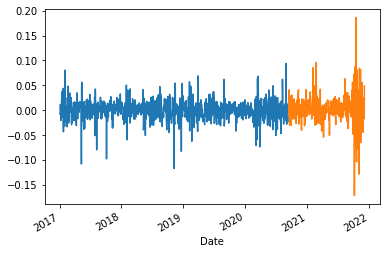

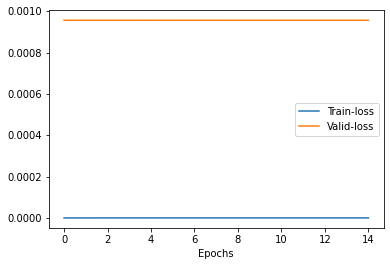

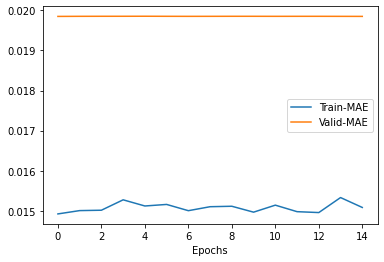

####################

Start training for stock: 1605
continuos shape: (1202, 9)  categorical shape: (1202, 4)
Epoch: <<< 0 >>>

                    Average train loss: 3.430973738431931e-07 | 
                    Train-Mae: 0.01835428550839424 |

                    Average val loss: 0.0006052263779565692|
                    Val-Mae: 0.01901034079492092
                    
.................... End of epoch 0 ....................
Epoch 00007: reducing learning rate of group 0 to 2.0833e-07.
Epoch: <<< 10 >>>

                    Average train loss: 3.404799790587276e-07 | 
                    Train-Mae: 0.018136750906705856 |

                    Average val loss: 0.0006050451193004847|
                    Val-Mae: 0.01900685951113701
                    
.................... End of epoch 10 ....................
Epoch 00013: reducing learning rate of group 0 to 1.0416e-07.


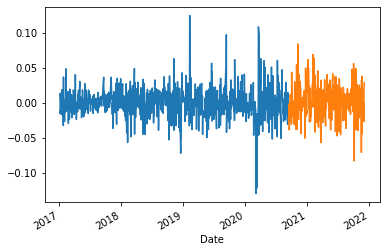

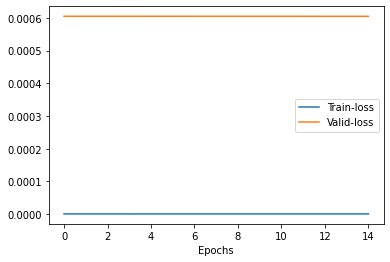

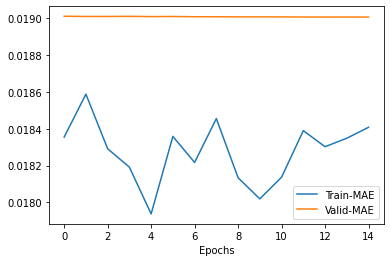

####################

CPU times: total: 12min 3s
Wall time: 12min 5s


In [6]:
%%time
stocks = train_df['SecuritiesCode'].unique()
count = 0
BATCH_SIZE = 512
weight_decay = 0.1
EPOCHS = 50


scaler_dict = {}

model = create_model()

trainer = Trainer(
    model, 
    optimizer_name='rmsprop', 
    lr=1.3333e-5, 
    weight_decay=weight_decay
)

torch.autograd.set_detect_anomaly(True)

for stock in stocks:
    train_loader, val_dataloader = None, None
    if count > 15:
        break
    print(f'Start training for stock: {stock}')

    train_dataloader, val_dataloader, scaler = dataloader_by_stock(
        train_df, 
        stock, 
        batch_size=BATCH_SIZE, 
        continous_cols=CONT_COLS,
        return_scaler=True
    )
    if count > 1:
        EPOCHS = 15
    trainer.fit_epochs(
        train_dataloader, 
        val_dataloader, 
        use_cyclic_lr=True, 
        x_cat=True, 
        epochs=EPOCHS
    )
    scaler_dict[stock] = scaler
    print('#' * 20)
    print()
    count += 1
    
trainer.save_model(model)
with open('scaler_dict.pkl', 'wb') as f:
    pickle.dump(scaler_dict, f)

### 